# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [22]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')

de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]

fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

full = df.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE'].drop(['DAY_ID', 'COUNTRY'], axis=1)
full_fr = full[full['COUNTRY'] == 'FR'].drop(['DAY_ID', 'COUNTRY'], axis=1)

# fix wind
fr_left_wind_mean, fr_left_wind_std = full_fr.loc[:1656, ['FR_WIND', 'DE_WIND']].mean(), full_fr.loc[:1656, ['FR_WIND', 'DE_WIND']].std()
fr_right_wind_mean, fr_right_wind_std = full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']].mean(), full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']].std()
full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']] = (((full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']] - fr_right_wind_mean) / fr_right_wind_std) * fr_left_wind_std) + fr_left_wind_mean

# fill wind
de_wind_gap = pd.read_csv('de_wind_reconstructed_gap.csv').set_index('ID').sort_index()
fr_wind_gap = pd.read_csv('fr_wind_reconstructed_gap.csv').set_index('ID').sort_index()
full_fr.loc[de_wind_gap.index, 'DE_WIND'] = de_wind_gap['0']
full_fr.loc[fr_wind_gap.index, 'FR_WIND'] = fr_wind_gap['0']

# for weather data, we must also fill it in for full_de
de_wind_gap.index = de_wind_gap.index - 1216
fr_wind_gap.index = fr_wind_gap.index - 1216
full_de.loc[de_wind_gap.index, 'DE_WIND'] = de_wind_gap['0']
full_de.loc[fr_wind_gap.index, 'FR_WIND'] = fr_wind_gap['0']

# fill exchange, import cols
de_import_gap_idx = full_fr[full_fr['DE_NET_IMPORT'].isna()].index
fr_import_gap_idx = full_fr[full_fr['FR_NET_IMPORT'].isna()].index
exchange_gap_idx = full_fr[full_fr['DE_FR_EXCHANGE'].isna()].index

de_import_gap = pd.read_csv('de_import_gap.csv').set_index('ID').sort_index()
fr_import_gap = pd.read_csv('fr_import_gap.csv').set_index('ID').sort_index()
exchange_gap = pd.read_csv('de_fr_exchange_gap.csv').set_index('ID').sort_index()

full_fr.loc[de_import_gap_idx, 'DE_NET_IMPORT'] = de_import_gap['0']
full_fr.loc[fr_import_gap_idx, 'FR_NET_IMPORT'] = fr_import_gap['0']
full_fr.loc[exchange_gap_idx, 'DE_FR_EXCHANGE'] = exchange_gap['0']

full_fr.loc[de_import_gap_idx, 'DE_NET_EXPORT'] = -de_import_gap['0']
full_fr.loc[fr_import_gap_idx, 'FR_NET_EXPORT'] = -fr_import_gap['0']
full_fr.loc[exchange_gap_idx, 'FR_DE_EXCHANGE'] = -exchange_gap['0']

# normalize dfs, for model analysis reasons
full_de_norm = full_de.copy()
full_de_norm = (full_de_norm - full_de_norm.mean()) / full_de_norm.std()

full_fr_norm = full_fr.copy()
full_fr_norm = (full_fr_norm - full_fr_norm.mean()) / full_fr_norm.std()

In [23]:
full_fr = full_fr.drop(['DE_TEMP', 'DE_RAIN', 'FR_TEMP', 'FR_RAIN'], axis=1)
full_de = full_de.drop(['DE_TEMP', 'DE_RAIN', 'FR_TEMP', 'FR_RAIN'], axis=1)

In [24]:
# reset de, fr
de = full_de[full_de.index.isin(de.index)]
fr = full_fr[full_fr.index.isin(fr.index)]

### Exploration

<Axes: xlabel='ID', ylabel='TARGET'>

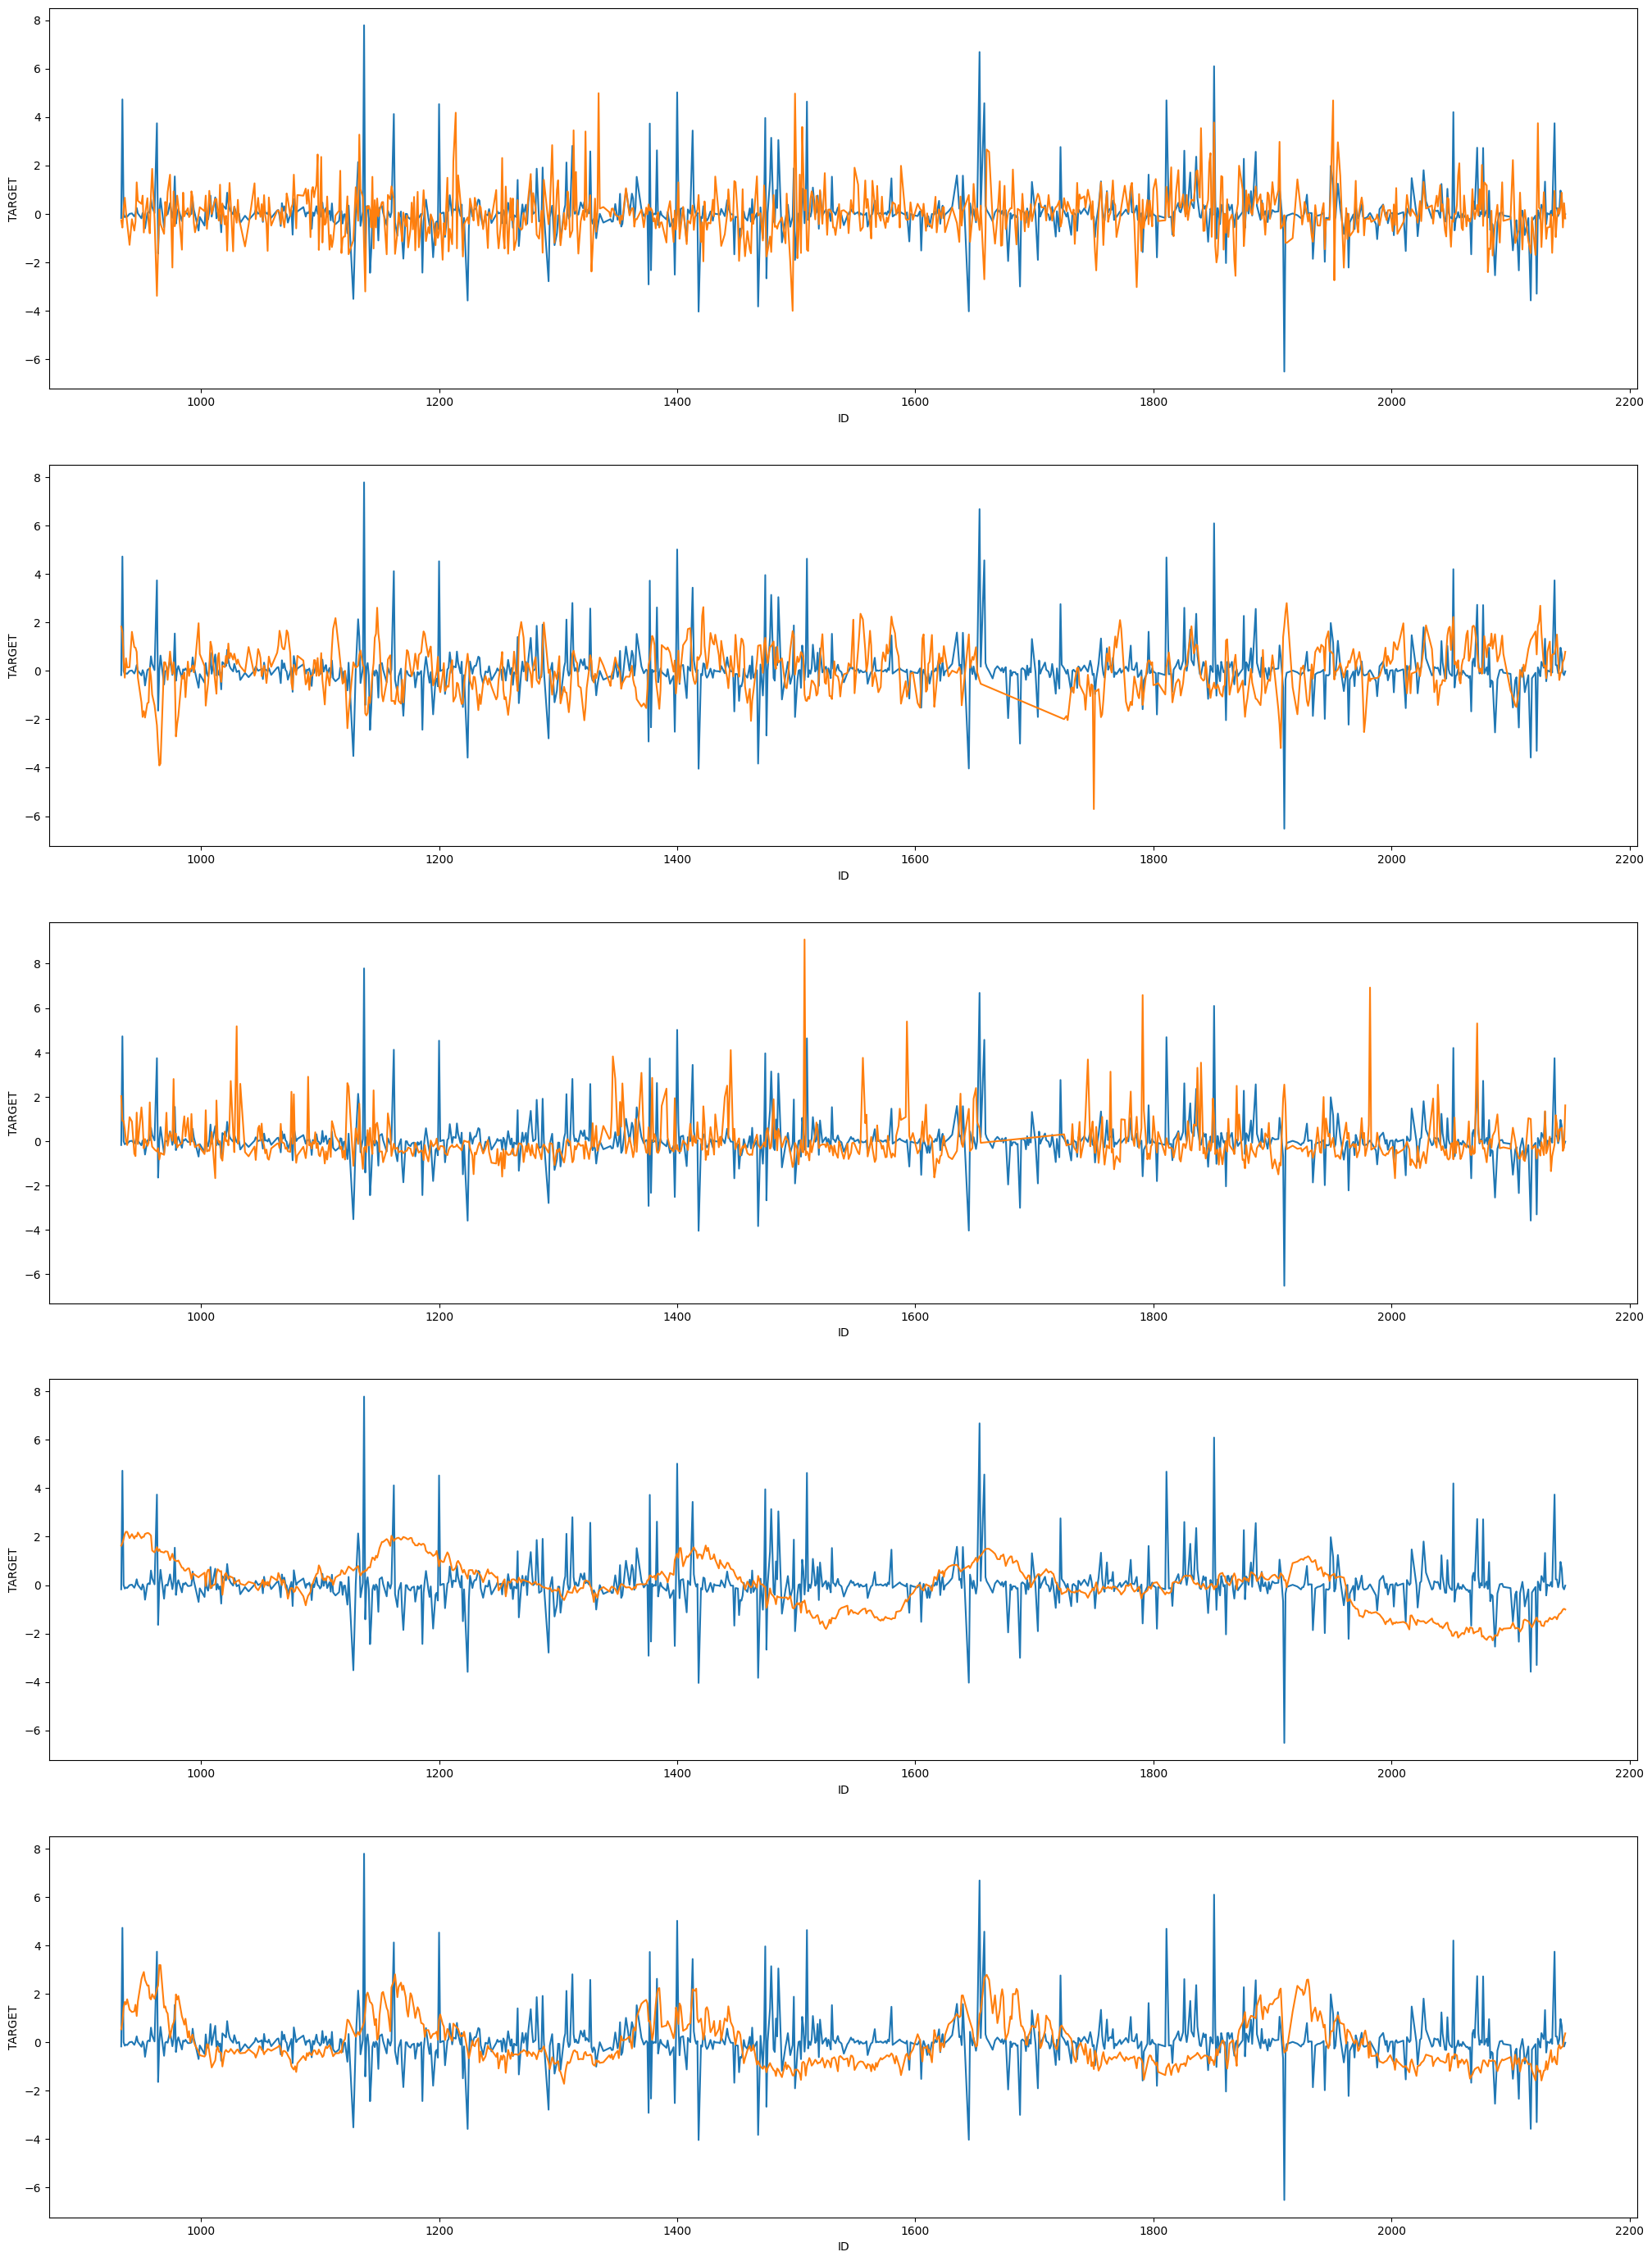

In [106]:
temp = full_fr_norm[full_fr_norm.index.isin(y_fr.index)]
num_ax = 5
fig, ax = plt.subplots(num_ax, figsize=(25, 35))
for i in range(num_ax):
    sns.lineplot(x=temp.index, y=y_fr['TARGET'], ax=ax[i])
sns.lineplot(x=temp.index, y=temp['CARBON_RET'], ax=ax[0])
sns.lineplot(x=temp.index, y=temp['FR_TEMP'], ax=ax[1])
sns.lineplot(x=temp.index, y=temp['FR_RAIN'], ax=ax[2])
sns.lineplot(x=temp.index, y=temp['FR_NUCLEAR'], ax=ax[3])
sns.lineplot(x=temp.index, y=temp['FR_RESIDUAL_LOAD'], ax=ax[4])

<Axes: xlabel='ID'>

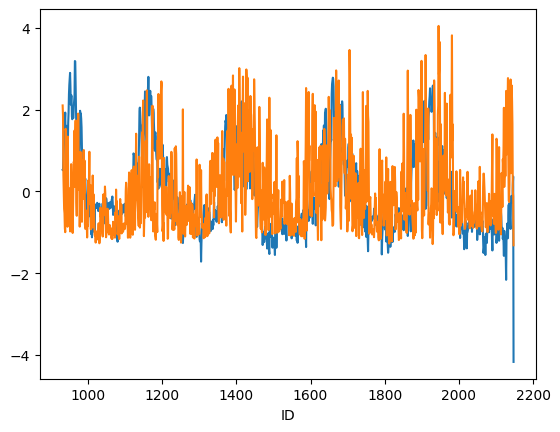

In [113]:
full_fr_norm['FR_RESIDUAL_LOAD'].plot()
full_fr_norm['FR_WINDPOW'].plot()

### Feature Engineering

#### Constants

In [52]:
fr_coal_on = -0.725

<Axes: xlabel='ID'>

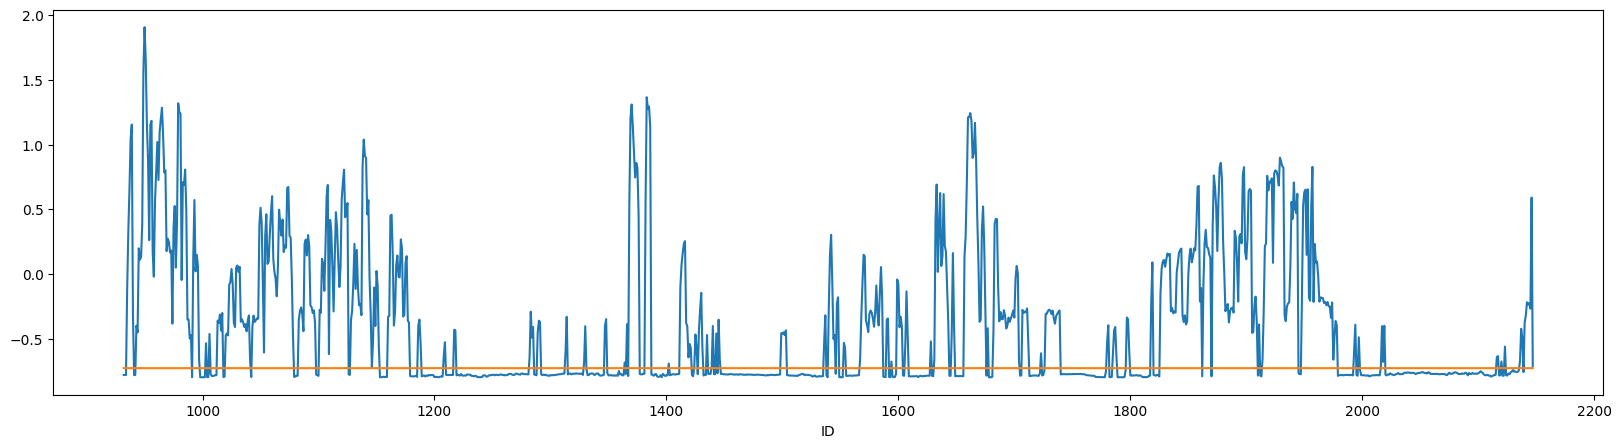

In [51]:
# when France turns on its coal plants, could mean something important about the performance of nuclear that day
fig, ax = plt.subplots(figsize=(20, 5))
full_fr['FR_COAL'].plot()
pd.Series(index=full_fr.index, data=fr_coal_on).plot()

In [59]:
full_fr['FR_COAL_ON'] = 1
full_fr.loc[full_fr['FR_COAL'] < fr_coal_on, 'FR_COAL_ON'] = 0

### Models

Trying various models.

TODO read through and implement stuff from here, paper notes that drivers of electricity prices are nonlinear: https://www.sciencedirect.com/science/article/pii/S0301421518307432

In [61]:
x = full_fr[full_fr.index.isin(y_fr.index)]
target = y_fr

In [62]:
x = x.drop(['FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT'], axis=1)

In [63]:
x['DAY_NUMBER'] = x.index

In [64]:
x.columns

Index(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_WIND', 'FR_WIND', 'GAS_RET', 'COAL_RET',
       'CARBON_RET', 'FR_COAL_ON', 'DAY_NUMBER'],
      dtype='object')

In [65]:
#########################################################################################################
# x_train, x_test, y_train, y_test = x, df_test, y['TARGET'], None
#########################################################################################################

In [66]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target['TARGET'], test_size=0.33, random_state=88, shuffle=False)

#### Baseline Linear Regression

fit on test set: -3.9%
fit on training set: 19.5%



<Axes: xlabel='ID', ylabel='TARGET'>

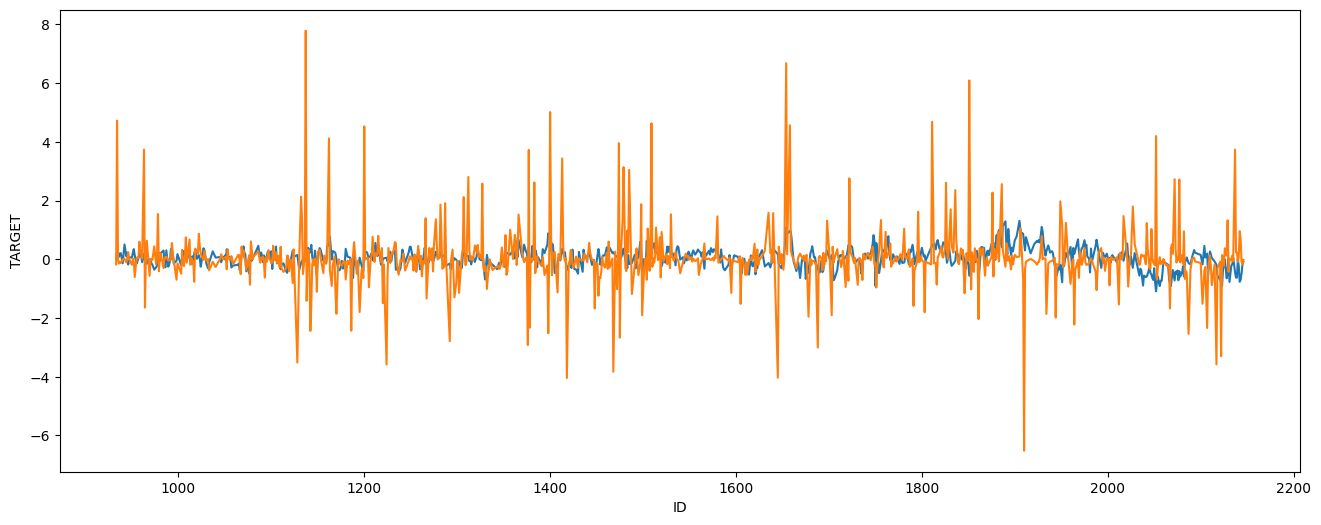

In [69]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

fig, ax = plt.subplots(figsize=(16, 6))
result = lr.predict(x)
sns.lineplot(x=target.index, y=result)
sns.lineplot(x=target.index, y=target['TARGET'])

#### Ridge Regression

fit on test set: -4.9%
fit on training set: 19.1%



<Figure size 640x480 with 0 Axes>

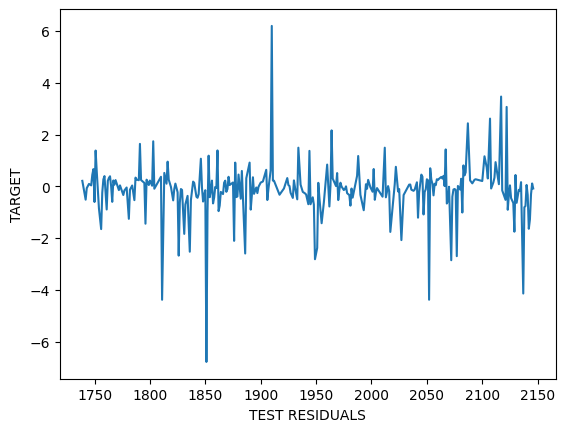

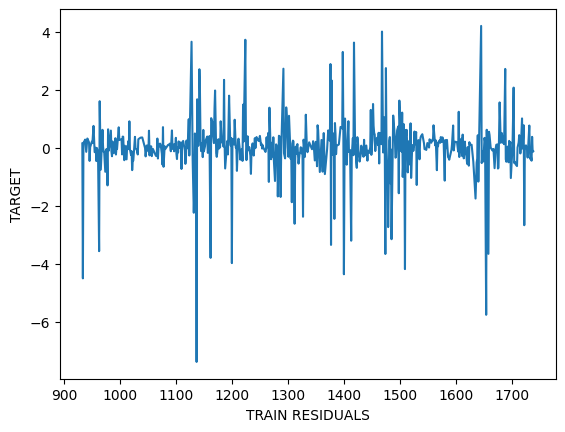

<Axes: xlabel='ID', ylabel='TARGET'>

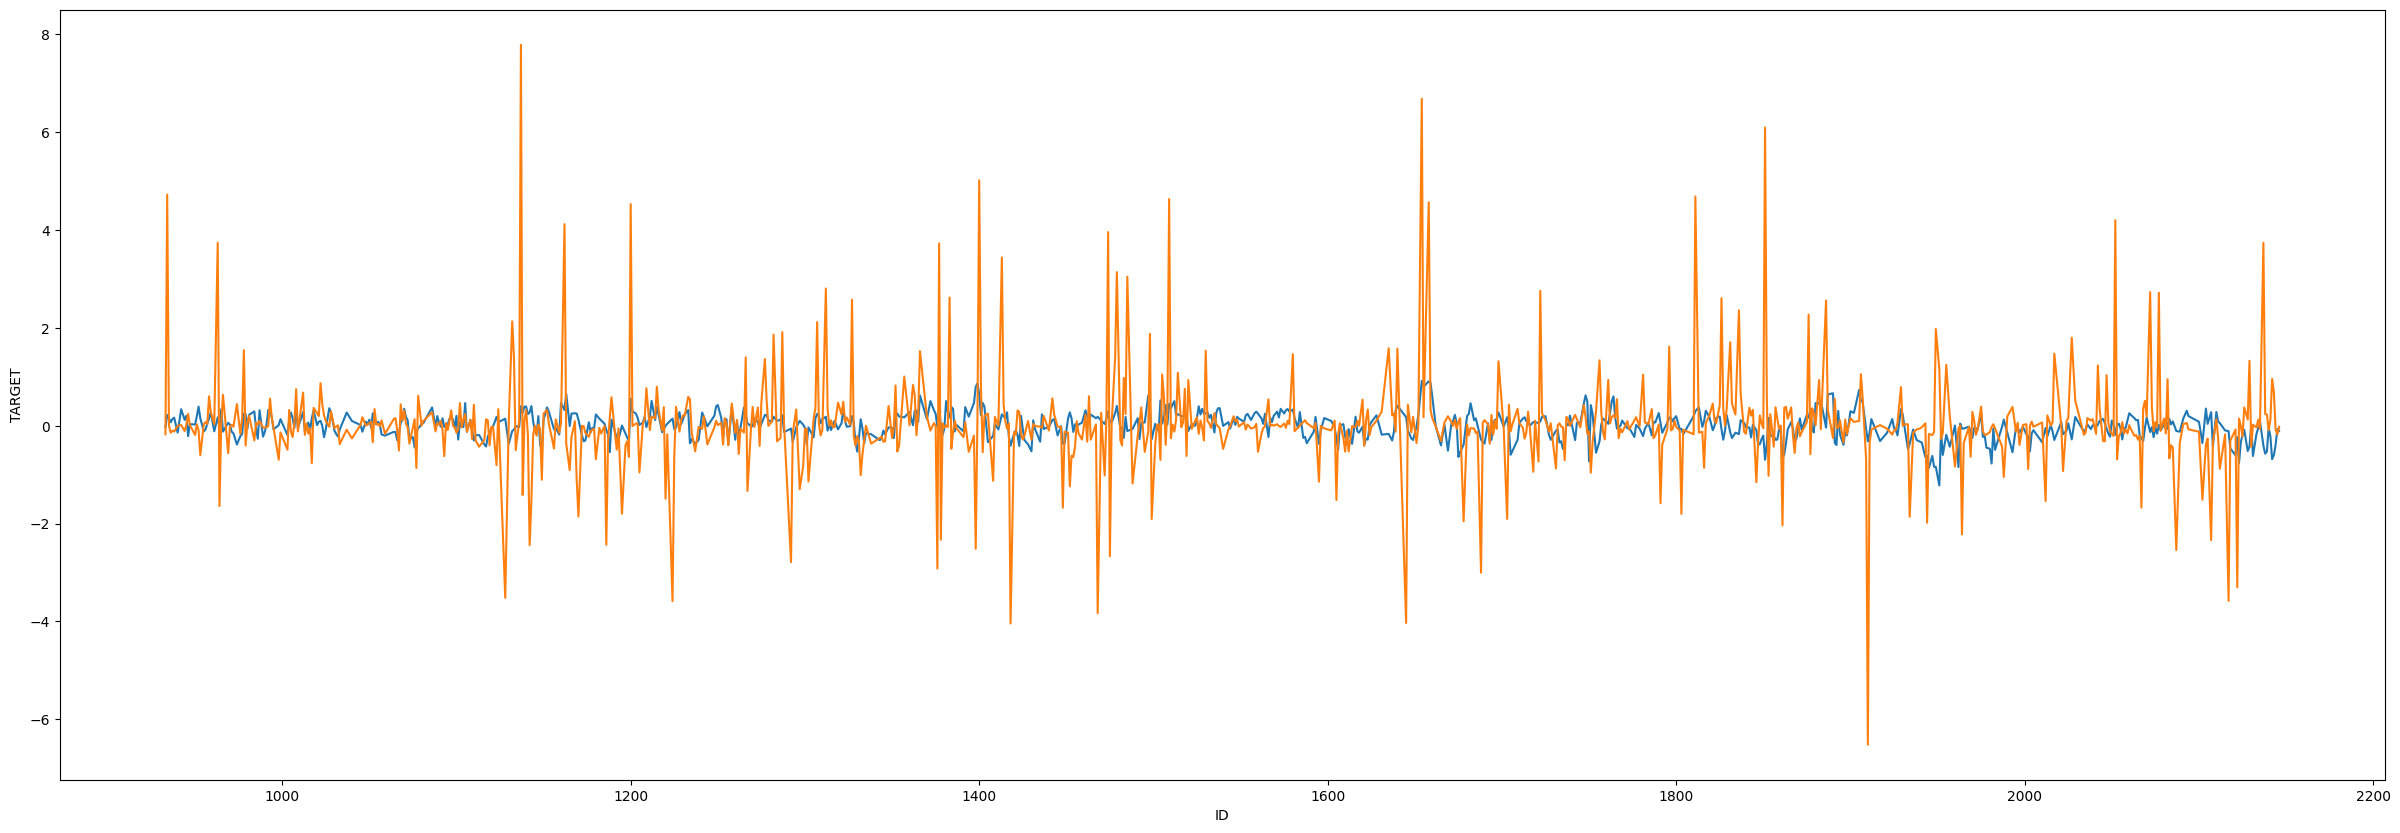

In [70]:
ridge = linear_model.Ridge(alpha=10)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=True)

fig, ax = plt.subplots(figsize=(30, 10))
result = ridge.predict(x)
sns.lineplot(x=target.index, y=result)
sns.lineplot(x=target.index, y=target['TARGET'])

<Axes: xlabel='ID', ylabel='TARGET'>

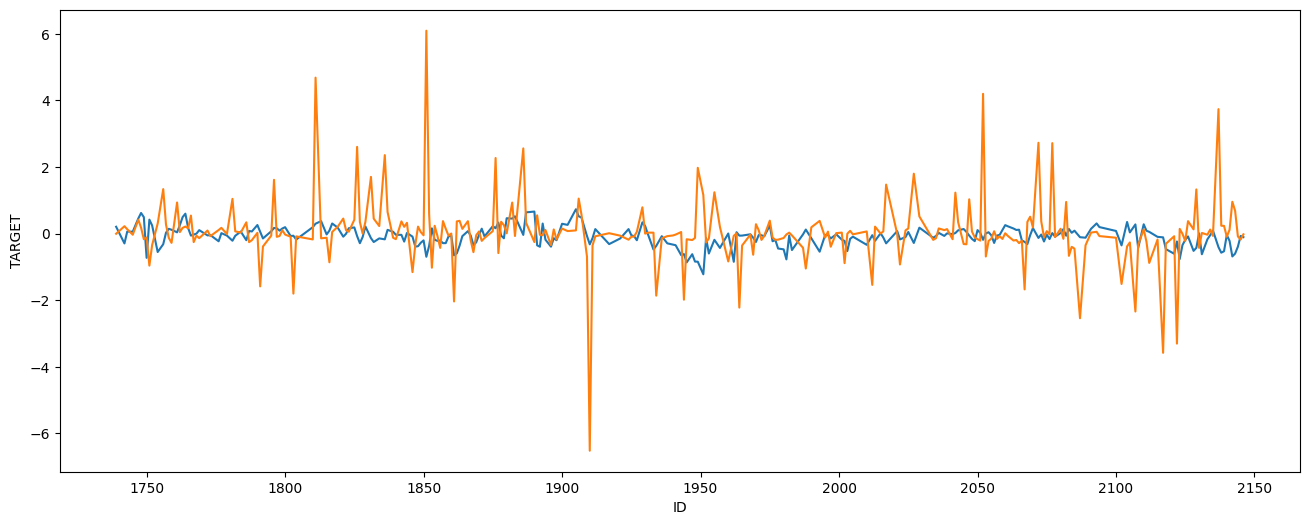

In [71]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=y_test.index, y=test_result)
sns.lineplot(x=y_test.index, y=y_test)

#### XGB Regression

fit on test set: 5.7%
fit on training set: 34.4%



<Axes: xlabel='ID', ylabel='TARGET'>

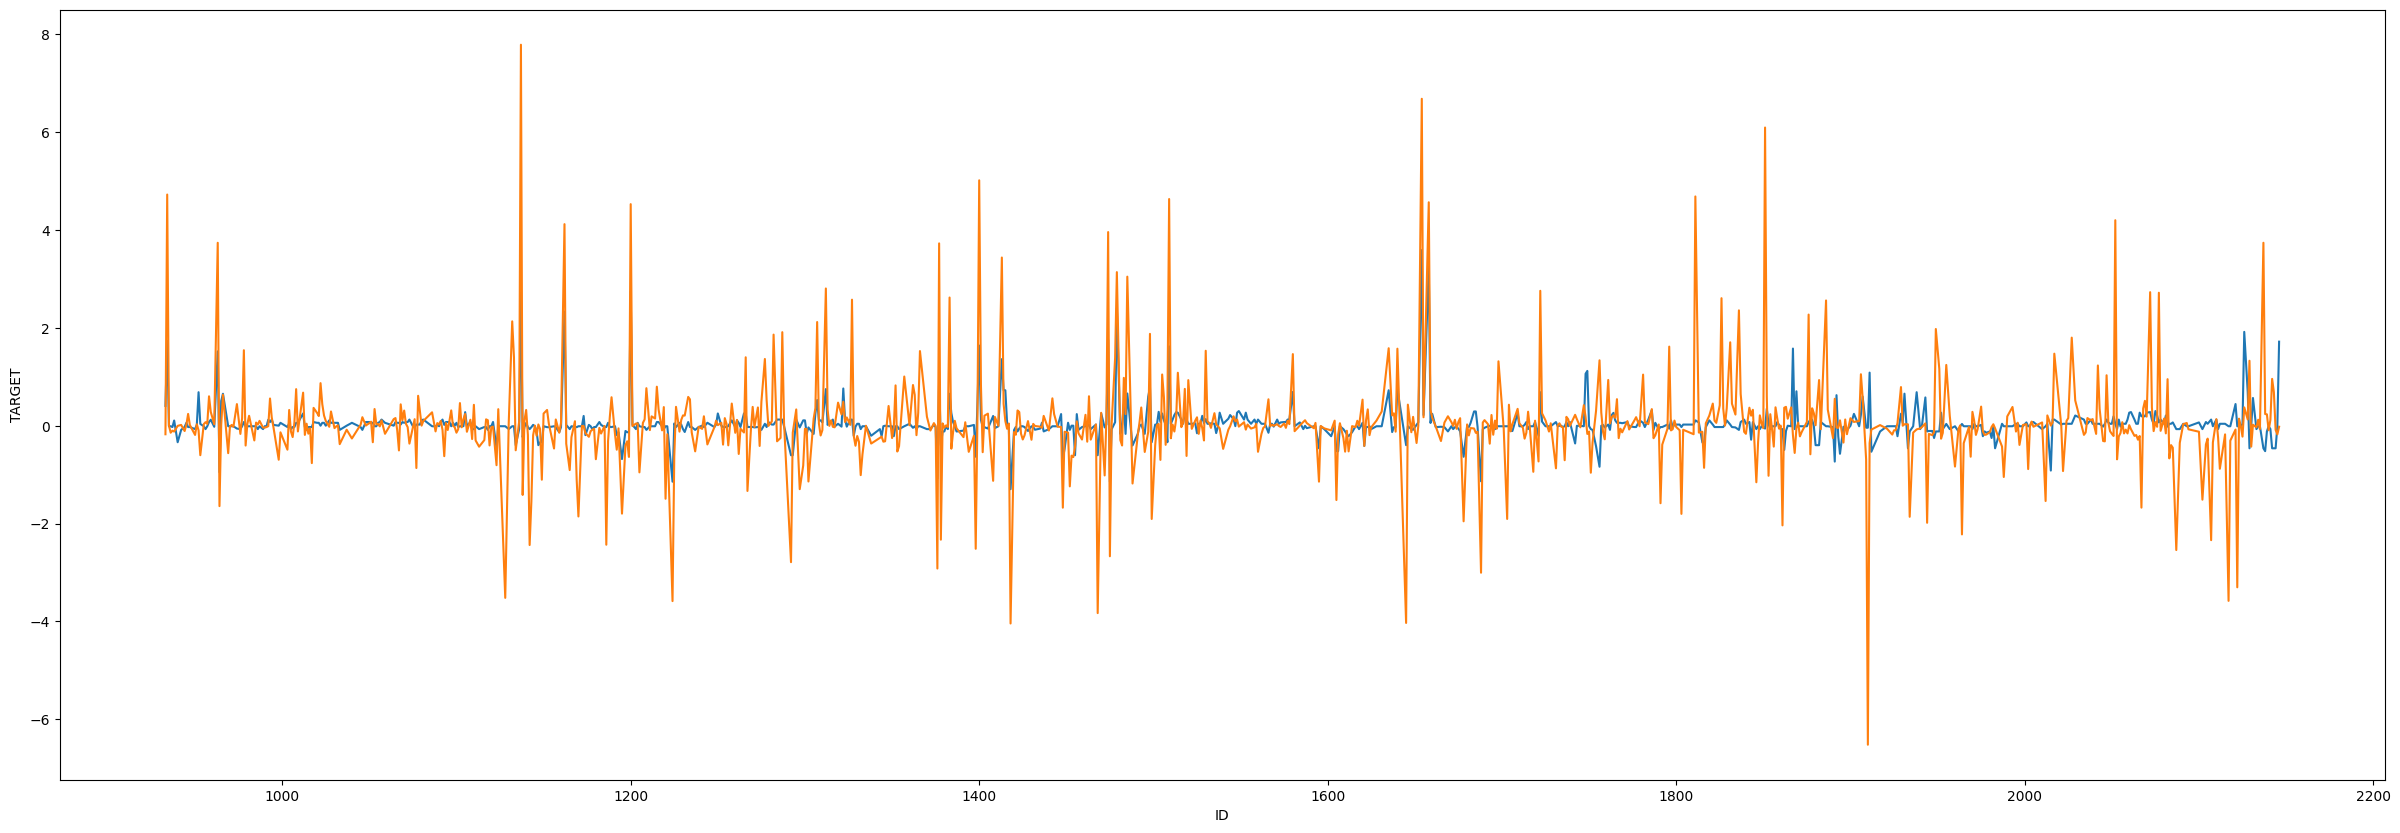

In [72]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=5)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

fig, ax = plt.subplots(figsize=(30, 10))
result = xgb_model.predict(x)
sns.lineplot(x=target.index, y=result)
sns.lineplot(x=target.index, y=target['TARGET'])

In [73]:
kf = KFold(n_splits = 5, shuffle=True)
kf_test_model(kf, xgb_model, x, target)

KeyError: "['DE_WIND_SQCB'] not in index"

#### Ridge Regression - XGB Hybrid

model_0 fit on test set: 40.3%
model_0 fit on train set: 40.7%
model_1 fit on test residuals: 16.0%
model_1 fit on train residuals: 78.4%
fit on test set: 37.3%
fit on training set: 80.8%



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

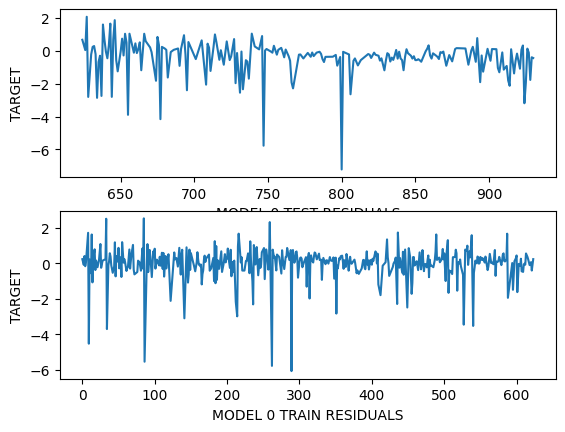

<Figure size 640x480 with 0 Axes>

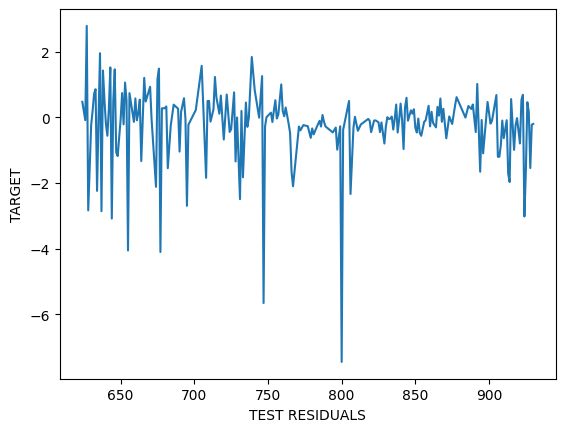

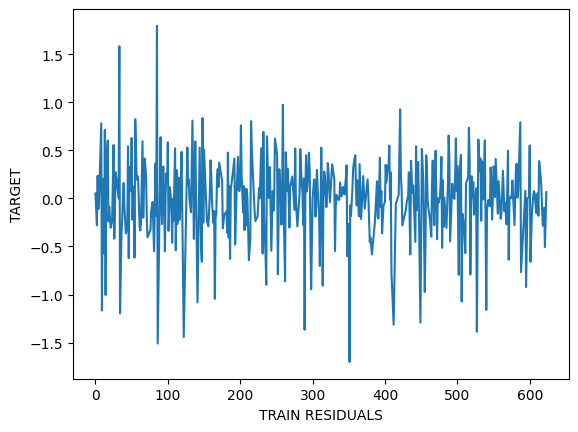

In [37]:
ridge = linear_model.Ridge(alpha=25)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=2)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

#### MLP Regressor

fit on test set: 1.9%
fit on training set: 17.7%



<Axes: xlabel='ID', ylabel='TARGET'>

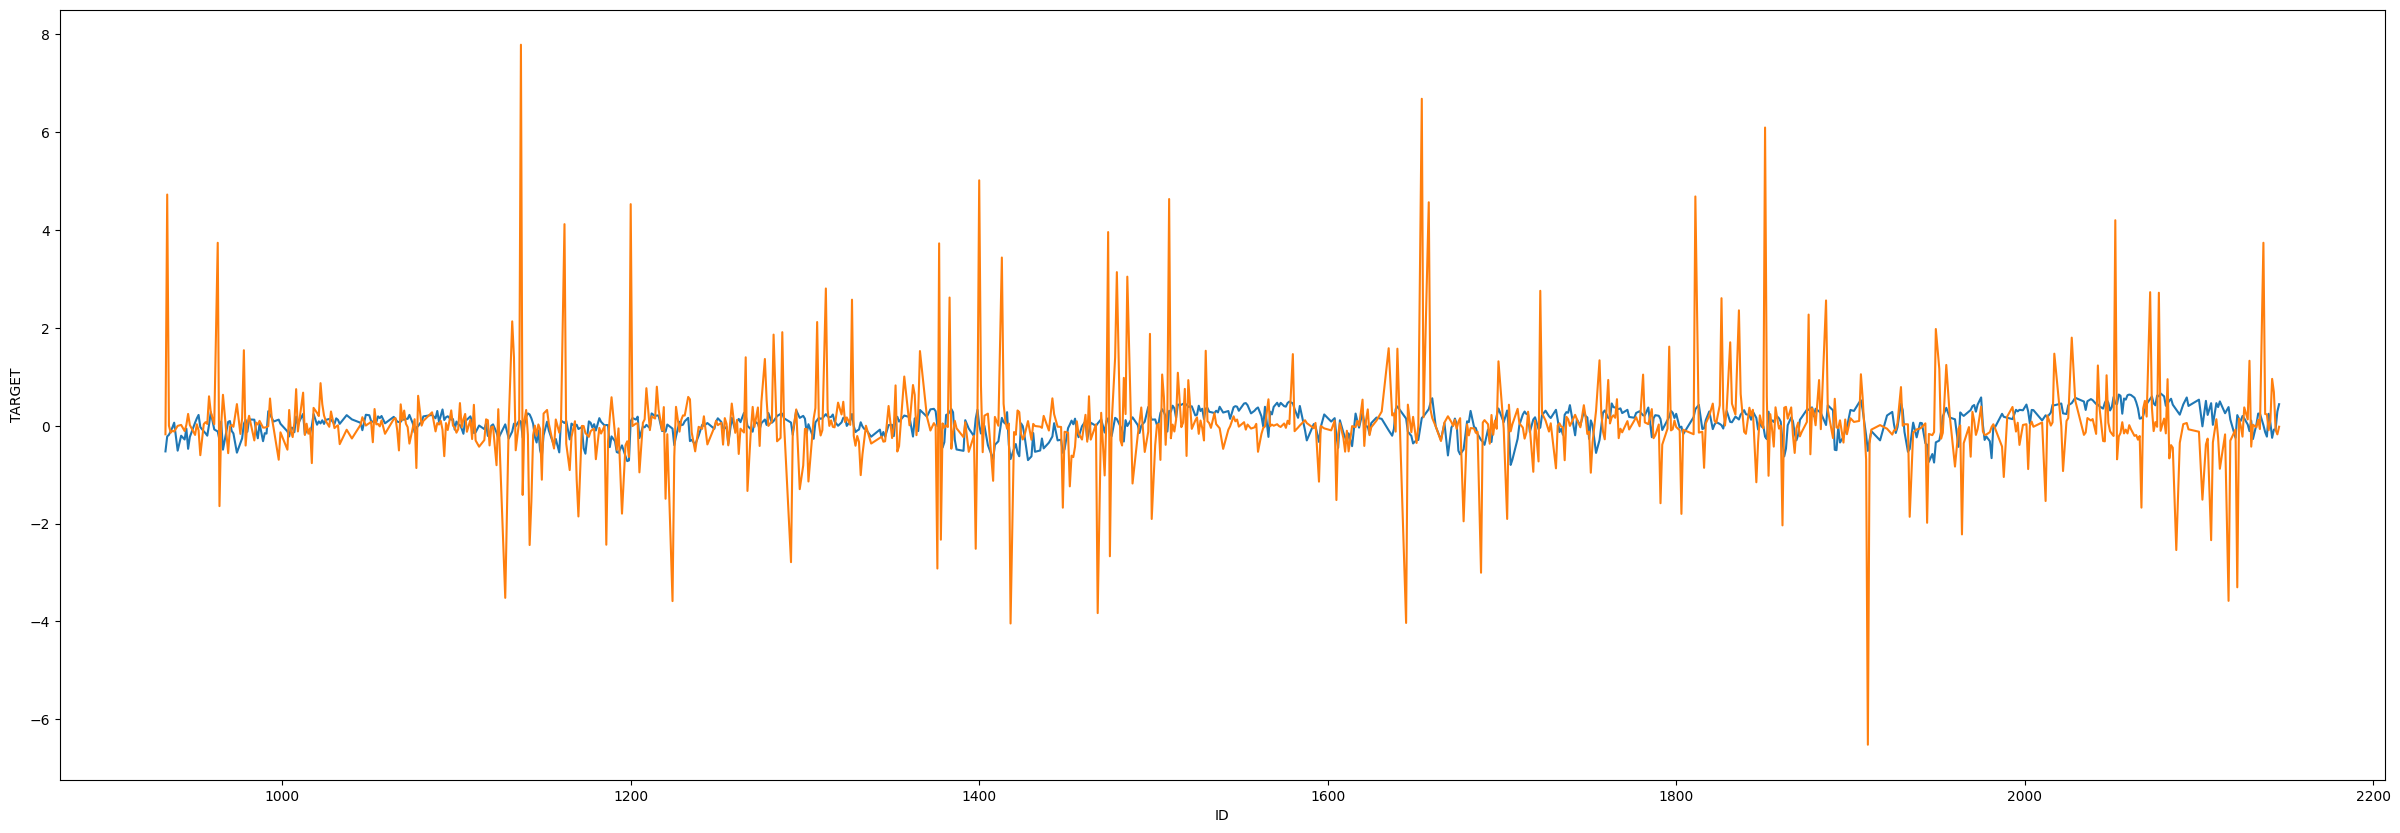

In [74]:
mlpr = MLPRegressor(alpha=15, solver='lbfgs', hidden_layer_sizes=(50, 20))
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test)

fig, ax = plt.subplots(figsize=(30, 10))
result = mlpr.predict(x)
sns.lineplot(x=target.index, y=result)
sns.lineplot(x=target.index, y=target['TARGET'])

#### MLP Regressor - XGB Hybrid

In [ ]:
x_train_lag = x_train.copy()
x_test_lag = x_test.copy()

In [ ]:
x_train_lag

In [ ]:
mlpr = MLPRegressor(alpha=0.01, solver='lbfgs', hidden_layer_sizes=(50, 20))
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

In [ ]:
kf = KFold(n_splits = 10)
kf_test_model(kf, mlpr, x, target, xgb_model)

### Submission

Make sure to change x_train and x_test to be the proper sets